# Decoding Responsivity (imbalanced learn)
**Can we predict whether a stimulus will be detected or not based on neuron's responsivity ?**

Célien Vandromme
18/04/2024

---

In [19]:
from unittest import result

import numpy as np
import pandas as pd


import percephone.core.recording as pc
import percephone.plts.stats as ppt
import os
import matplotlib
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count, pool
import warnings
import seaborn as sns
import copy
from statistics import mean

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from scipy.stats import mannwhitneyu
import imblearn as imb
from percephone.analysis.utils import neuron_mean_std_corr
import matplotlib.ticker as mtick

plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline
warnings.filterwarnings('ignore')
fontsize = 30
%config InlineBackend.figure_format = 'retina'

In [20]:
user = "Célien"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data/"
    roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
    server_address = "Z:/Current_members/Ourania_Semelidou/2p/Figures_paper/"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
    
roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    rec.peak_delay_amp()
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
    pool = Pool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorpor

In [21]:
names = ["ID", "genotype", "stim", "stim_True", "stim_False", "neuron_exc", "neuron_inh"]
matrix = []
for rec in recs.values():
    ind = []
    ind.append(rec.filename)
    ind.append(rec.genotype)
    ind.append(len(rec.detected_stim))
    ind.append(rec.detected_stim.sum())
    ind.append(len(rec.detected_stim) - rec.detected_stim.sum())
    ind.append(rec.matrices["EXC"]["Responsivity"].shape[0])
    ind.append(rec.matrices["INH"]["Responsivity"].shape[0])
    matrix.append(ind)
summary = pd.DataFrame(np.array(matrix), columns=names)
summary

,ID,genotype,stim,stim_True,stim_False,neuron_exc,neuron_inh
0,5889,WT,54,46,8,49,15
1,6601,KO-Hypo,62,28,34,103,22
2,4939,WT,54,25,29,101,19
3,5893,KO,80,37,43,58,13
4,5886,WT,82,65,17,38,9
5,4456,WT,87,58,29,127,14
6,6611,KO-Hypo,66,9,57,84,18
7,5873,WT,27,19,8,91,29
8,5881,KO-Hypo,53,24,29,103,19
9,5879,WT,68,45,23,55,18


In [22]:
def resp_heatmap(record_dict, sort=False):
    if sort:
        X_train_true = record_dict["X_train"][record_dict["y_train"] == True]
        y_train_true = np.ones(X_train_true.shape[0], dtype=bool)
        X_train_false = record_dict["X_train"][record_dict["y_train"] == False]
        y_train_false = np.zeros(X_train_false.shape[0], dtype=bool)
        X_new = record_dict["X_bal"][X_train_true.shape[0] + X_train_false.shape[0]:]
        y_new = record_dict["y_bal"][X_train_true.shape[0] + X_train_false.shape[0]:]
        X = np.row_stack((X_train_true, X_train_false, X_new))
        y = np.append(y_train_true, np.append(y_train_false, y_new))
    else:
        X = record_dict["X_bal"]
        y = record_dict["y_bal"]

    plt.figure(figsize=(12, 6))
    sns.heatmap(X.T, cmap='plasma', xticklabels=y, cbar_kws={'label': 'Responsivity'})
    plt.axvline(x=record_dict["X_train"].shape[0], color="black", linewidth=1)
    if sort:
        plt.axvline(x=X_train_true.shape[0], color="black", linewidth=1, linestyle='dashed')
    plt.title(f"{record_dict['filename']}({record_dict['genotype']}) Neuron Responses to Stimuli")
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.xlabel("Detected stimulation")
    plt.ylabel("Neurons")
    plt.show()

In [23]:
def get_rec_info(rec, parameter, estimator=None, exc_neurons=True, inh_neurons=False):
    result = {}
    result["genotype"] = rec.genotype
    result["filename"] = rec.filename
    result["threshold"] = rec.threshold
    result["stim_ampl"] = rec.stim_ampl
    result["y"] = rec.detected_stim
    
    if parameter == "zscore":
        exc_data = np.empty((0, rec.zscore_exc.shape[0]))
        inh_data = np.empty((0, rec.zscore_inh.shape[0]))
        for i, start in enumerate(rec.stim_time):
            end = start + int(rec.stim_durations[i])
            new_exc = neuron_mean_std_corr(rec.zscore_exc[:, start : end].T, estimator)
            new_inh = neuron_mean_std_corr(rec.zscore_inh[:, start : end].T, estimator)
            exc_data = np.row_stack((exc_data, new_exc))
            inh_data = np.row_stack((inh_data, new_inh))
        exc_data = exc_data.T
        inh_data = inh_data.T
    else:
        exc_data = rec.matrices["EXC"][parameter]
        inh_data = rec.matrices["INH"][parameter]
    
    if exc_neurons and inh_neurons:
        result["X"] = np.row_stack((exc_data, inh_data)).T
        result["neurons"] = "EXC & INH"
    elif exc_neurons:
        result["X"] = exc_data.T
        result["neurons"] = "EXC"
    elif inh_neurons:
        result["X"] = inh_data.T
        result["neurons"] = "INH"
    return result

In [7]:
def stim_ampl_filter(record, stim_ampl="all"):
    all_ampl = np.arange(0, 14, 2)
    if stim_ampl == "threshold":
        amplitudes = record["threshold"]
    elif stim_ampl == "supra":
        amplitudes = all_ampl[all_ampl >= record["threshold"]]
    elif stim_ampl == "sub":
        amplitudes = all_ampl[all_ampl < record["threshold"]]
    elif stim_ampl == "all":
        return record
    else:
        amplitudes = np.array(stim_ampl)
    selected_stim = np.isin(record["stim_ampl"], amplitudes)
    record["X"] = record["X"][selected_stim]
    record["y"] = record["y"][selected_stim]
    return record

In [25]:
def split_data(record_dict, train_ratio=0.8, stratify=False, seed=None):
    if train_ratio == 1:
        record_dict["X_train"], record_dict["X_test"], record_dict["y_train"], record_dict["y_test"] = record_dict["X"], [], record_dict["y"], []
    else:
        if stratify:
            record_dict["X_train"], record_dict["X_test"], record_dict["y_train"], record_dict["y_test"] = train_test_split(record_dict["X"], record_dict["y"], 
                                                                                                                            train_size=train_ratio,
                                                                                                                            stratify=record_dict["y"],
                                                                                                                            random_state=seed)
        else:
            record_dict["X_train"], record_dict["X_test"], record_dict["y_train"], record_dict["y_test"] = train_test_split(record_dict["X"], record_dict["y"], 
                                                                                                                            train_size=train_ratio,
                                                                                                                            stratify=None,
                                                                                                                            random_state=seed)
    return record_dict

In [26]:
def resample(record_dict, resampler):
    record_dict["X_bal"], record_dict["y_bal"] = resampler.fit_resample(record_dict["X_train"], record_dict["y_train"])
    return record_dict

In [27]:
def confusion_matrix_scorer(model, X, y):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred, labels=[False, True])
    return {'TN': cm[0, 0], 'FP': cm[0, 1],
            'FN': cm[1, 0], 'TP': cm[1, 1]}


In [11]:
def get_sen_spe_acc(conf_matrix):
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return sensitivity, specificity, accuracy


In [69]:
def random_over_under(X_train, y_train, over_prop=0.5):
    n_class_1 = sum(y_train)
    n_class_2 = len(y_train) - sum(y_train)
    if  n_class_1 == n_class_2:
        return X_train, y_train
    elif n_class_1 > n_class_2:
        n_min = n_class_2
        n_maj = n_class_1
    else:
        n_min = n_class_1
        n_maj = n_class_2
        
    alpha_over = ((n_min + n_maj)/2)/n_maj
    ros = imb.over_sampling.RandomOverSampler(sampling_strategy=alpha_over*(over_prop*2))
    rus = imb.under_sampling.RandomUnderSampler(sampling_strategy=1)
    X_bal_0, y_bal_0 = ros.fit_resample(X_train, y_train)
    X_bal, y_bal = rus.fit_resample(X_bal_0, y_bal_0)
    print(f"n_maj: {n_maj}, n_min: {n_min}, alpha_over: {alpha_over:.2f}, y_bal_0: {len(y_bal_0)}, y_bal: {len(y_bal)}")
    return X_bal, y_bal

In [70]:
def crossval_sen_spe_acc(model, X, y, kfold=5, stratify=True, shuffle=True, resampler=None, over_prop=0.5):
    sensitivities = []
    specificities = []
    accuracies = []
    if stratify:
        kf = StratifiedKFold(n_splits=kfold, shuffle=shuffle)
    else:
        kf = KFold(n_splits=kfold, shuffle=shuffle)
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if resampler == "ROS-RUS":
            X_bal, y_bal = random_over_under(X_train, y_train, over_prop=over_prop)
            model.fit(X_bal, y_bal)
        elif resampler is not None:
            X_bal, y_bal = resampler.fit_resample(X_train, y_train)
            print(f"y_bal: {len(y_bal)} -> {len(y_bal)/(len(y_train)+len(y_test))*100:.1f}%, y_test: {len(y_test)} -> {len(y_test)/(len(y_train)+len(y_test))*100:.1f}%")
            model.fit(X_bal, y_bal)
        else:
            print(f"y_train: {len(y_train)} -> {len(y_train)/(len(y_train)+len(y_test))*100:.1f}%, y_test: {len(y_test)} -> {len(y_test)/(len(y_train)+len(y_test))*100:.1f}%")
            model.fit(X_train, y_train)
            
        conf_mat = confusion_matrix(y_test, model.predict(X_test), labels=[False, True])
        sen, spe, acc = get_sen_spe_acc(conf_mat)
        sensitivities.append(sen)
        specificities.append(spe)
        accuracies.append(acc)
    return np.nanmean(sensitivities), np.nanmean(specificities), np.nanmean(accuracies)

In [30]:
# Test cell
rec = recs[4456]
model = LogisticRegression(penalty="l2")
resampler = imb.over_sampling.RandomOverSampler(sampling_strategy='auto', shrinkage=None)

record = get_rec_info(rec, "Responsivity", estimator=None, exc_neurons=True, inh_neurons=True)
record = split_data(record, train_ratio=0.8, stratify=True, seed=42)
record = resample(record, resampler)

# function test
stratify = True
kfold = 5
X = record["X_bal"]
y = record["y_bal"]

sensitivities = []
specificities = []
accuracies = []
if stratify:
    kf = StratifiedKFold(n_splits=kfold, shuffle=True)
else:
    kf = KFold(n_splits=kfold, shuffle=True)

for train_index, test_index in kf.split(X, y):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    model.fit(X_train, y_train)
    conf_mat = confusion_matrix(y_test, model.predict(X_test), labels=[False, True])
    
    TP = conf_mat[1, 1]
    TN = conf_mat[0, 0]
    FP = conf_mat[0, 1]
    FN = conf_mat[1, 0]

    sen = TP / (TP + FN)
    spe = TN / (TN + FP)
    acc = (TP + TN) / (TP + TN + FP + FN)
    
    sensitivities.append(sen)
    specificities.append(spe)
    accuracies.append(acc)

In [14]:
rec = recs[4456]
model = LogisticRegression(penalty="l2")
resampler = imb.over_sampling.RandomOverSampler(sampling_strategy='auto', shrinkage=None)

record = get_rec_info(rec, "Responsivity", estimator=None, exc_neurons=True, inh_neurons=True)
record = split_data(record, train_ratio=0.8, stratify=True, seed=42)
record = resample(record, resampler)

crossval_sen_spe_acc(model, record["X_bal"], record["y_bal"])

y_train: 73 -> 79.3%, y_test: 19 -> 20.7%
y_train: 73 -> 79.3%, y_test: 19 -> 20.7%
y_train: 74 -> 80.4%, y_test: 18 -> 19.6%
y_train: 74 -> 80.4%, y_test: 18 -> 19.6%
y_train: 74 -> 80.4%, y_test: 18 -> 19.6%


(0.9111111111111111, 0.9133333333333333, 0.9134502923976606)

In [73]:
def apply_model(model, parameter, estimator=None, resampler=None, 
                exc_neurons=True, inh_neurons=True, amplitudes="all", 
                train_ratio=1, tt_stratify=True, 
                cv_stratify=True, shuffle=True, cv=5, cv_resampler=None, plot_cv_metrics=True, 
                seed=None, silent_call=False, save_figure=False, over_prop=0.5):
    mean_cv_scores = [[], [], []]
    
    cv_sen_list = [[], [], []]
    cv_spe_list = [[], [], []]
    cv_acc_list = [[], [], []]
    
    accuracies = [[], [], []]
    sensitivities = [[], [], []]
    specificities = [[], [], []]
    
    models_dict = {}
    
    if not silent_call:
        fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(15, 10), sharex=True)
    i_wt = 0
    i_ko = 0
        
    for rec in recs.values():
        # Defining the variable gen_id according to genotype, used to group accuracies, sensitivities, ...etc by genotype
        if rec.genotype == "WT":
            genotype_id = 0
        elif rec.genotype == "KO-Hypo":
            genotype_id = 1
        elif rec.genotype == "KO":
            genotype_id = 2
        
        try:
            record = get_rec_info(rec, parameter, estimator=estimator, exc_neurons=exc_neurons, inh_neurons=inh_neurons)
            record = stim_ampl_filter(record, stim_ampl=amplitudes)
            record = split_data(record, train_ratio=train_ratio, stratify=tt_stratify, seed=seed)
            test_size = record["y_test"].shape[0] if train_ratio != 1 else 0
            
            if resampler is not None:
                record = resample(record, resampler)
                new_samples = record["y_bal"].shape[0] - record["y_train"].shape[0]
                model.fit(record["X_bal"], record["y_bal"])
                cv_scores = cross_val_score(model, record["X_bal"], record["y_bal"], cv=cv)
                cv_sen, cv_spe, cv_acc = crossval_sen_spe_acc(model, record["X_bal"], record["y_bal"], kfold=cv, stratify=cv_stratify, shuffle=shuffle, resampler=cv_resampler, over_prop=over_prop)
                # Generated label
                gen_lab = str(record["y_bal"][-1])
            else:
                new_samples = 0
                model.fit(record["X_train"], record["y_train"])
                cv_scores = cross_val_score(model, record["X_train"], record["y_train"], cv=cv)
                cv_sen, cv_spe, cv_acc = crossval_sen_spe_acc(model, record["X_train"], record["y_train"], kfold=cv, stratify=cv_stratify, shuffle=shuffle, resampler=cv_resampler, over_prop=over_prop)
        except ValueError:
            print(f"The model could not be trained on {rec.filename}")
            continue
            
        # Saving model for plotting the weights
        models_dict[f"{record['filename']} ({record['genotype']})"] = copy.copy(model)
        
        # Cross-validation
        mean_cv_scores[genotype_id].append(cv_scores.mean())
        
        # Metrics on test data
        if train_ratio != 1:
            y_pred = model.predict(record["X_test"])
            conf_matrix = confusion_matrix(record["y_test"], y_pred, labels=[False, True])
            sensitivity, specificity, accuracy = get_sen_spe_acc(conf_matrix)
            
            accuracies[genotype_id].append(accuracy)
            sensitivities[genotype_id].append(sensitivity)
            specificities[genotype_id].append(specificity)
        
        cv_sen_list[genotype_id].append(cv_sen)
        cv_spe_list[genotype_id].append(cv_spe)
        cv_acc_list[genotype_id].append(cv_acc)
        
        # Boxplot of each recording
        if rec.genotype == "WT":
            i = copy.copy(i_wt)
            j = 0
            i_wt += 1
        else:
            i = copy.copy(i_ko)
            j = 1
            i_ko += 1
        
        if not silent_call:
            ax[i, j].boxplot(cv_scores, vert=False, widths=.4)
            ax[i, j].scatter(cv_scores, np.ones(cv), s=10)
            # test set metrics plotting
            if train_ratio != 1:
                ax[i, j].axvline(x=specificity, color="green", linewidth=1, linestyle=":")
                ax[i, j].axvline(x=sensitivity, color="orange", linewidth=1, linestyle=":")
                ax[i, j].axvline(x=accuracy, color="red", linewidth=1, linestyle=":")
            # cv metrics plotting
            ax[i, j].axvline(x=cv_spe, color="green", linewidth=1.5, linestyle="--")
            ax[i, j].axvline(x=cv_sen, color="orange", linewidth=1.5, linestyle="--")
            ax[i, j].axvline(x=cv_acc, color="red", linewidth=1.5, linestyle="--")
            if resampler is not None:
                if train_ratio != 1:
                    ax[i, j].set_title(f"{rec.filename} ({rec.genotype})[{record['y_bal'].shape[0]}N:{new_samples}({gen_lab}) T:{test_size}] - CV({cv_scores.mean():.1%}) Ac({cv_acc:.1%}/{accuracy:.1%}) Sp({cv_spe:.1%}/{specificity:.1%}) Se({cv_sen:.1%}/{sensitivity:.1%})", size=10)
                else:
                    ax[i, j].set_title(f"{rec.filename} ({rec.genotype})[{record['y_bal'].shape[0]}N:{new_samples}({gen_lab}) T:{test_size}] - CV({cv_scores.mean():.1%}) Ac({cv_acc:.1%}) Sp({cv_spe:.1%}) Se({cv_sen:.1%})", size=10)
            else:
                if train_ratio != 1:
                    ax[i, j].set_title(f"{rec.filename} ({rec.genotype})[T:{test_size}] - CV({cv_scores.mean():.1%}) Ac({cv_acc:.1%}/{accuracy:.1%}) Sp({cv_spe:.1%}/{specificity:.1%}) Se({cv_sen:.1%}/{sensitivity:.1%})", size=10)
                else:
                    ax[i, j].set_title(f"{rec.filename} ({rec.genotype})[T:{test_size}] - CV({cv_scores.mean():.1%}) Ac({cv_acc:.1%}) Sp({cv_spe:.1%}) Se({cv_sen:.1%})", size=10)
            ax[i, j].spines["left"].set_visible(True)
    if not silent_call:
        if train_ratio != 1:
            plt.suptitle(f"Decoding {parameter} [{resampler}/{model}] - Train size: {train_ratio:.1%} - CV: {cv} fold")
        else:
            plt.suptitle(f"Decoding {parameter} [{cv_resampler}/{model}] - CV: {cv} fold - Stratify: {cv_stratify}, shuffle: {shuffle}")
        plt.show()
    
    # Boxplots of sensitivity, specificity and accuracy by genotype
    if plot_cv_metrics:
        data_wt = [cv_sen_list[0], cv_spe_list[0], cv_acc_list[0]]
        data_koh = [cv_sen_list[1], cv_spe_list[1], cv_acc_list[1]]
    else:
        data_wt = [sensitivities[0], specificities[0], accuracies[0]]
        data_koh = [sensitivities[1], specificities[1], accuracies[1]]
    
    if not silent_call:
        fig2, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18, 8))
        ppt.boxplot(axs[0], data_wt[0], data_koh[0], ylabel="Accuracy", paired=False, title="Detected", colors=[ppt.wt_color, ppt.hypo_color], ylim=[0, 1])
        ppt.boxplot(axs[1], data_wt[1], data_koh[1], ylabel="Accuracy", paired=False, title="Undetected", colors=[ppt.wt_light_color, ppt.hypo_light_color], ylim=[0, 1])
        ppt.boxplot(axs[2], data_wt[2], data_koh[2], ylabel="Accuracy", paired=False, title="All", colors=[ppt.wt_color, ppt.hypo_color], ylim=[0, 1])
        axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
        axs[1].get_yaxis().set_visible(False)
        axs[2].get_yaxis().set_visible(False)
        axs[1].spines["left"].set_visible(False)
        axs[2].spines["left"].set_visible(False)
        if train_ratio != 1:
            fig2.suptitle(f"Decoding {parameter} [{resampler}/{model}]")
        else:
            fig2.suptitle(f"Decoding {parameter} [{cv_resampler}/{model}] - CV: {cv} fold - Stratify: {cv_stratify}, shuffle: {shuffle}")
        plt.tight_layout()
        if save_figure:
            title = f"Figure2/responsivity/fr_n_{t_pattern}_{stim_ampl}.pdf"
            fig2.savefig(server_address + title)
        
        # Plotting the weights
        # print(len(models_dict["4456 (WT)"].coef_[0]))
    
    return data_wt, data_koh

In [16]:
f_wt_se, f_wt_sp, f_wt_ac = [], [], []
f_ko_se, f_ko_sp, f_ko_ac = [], [], []
f_wt_se1, f_wt_sp1, f_wt_ac1 = [], [], []
f_ko_se1, f_ko_sp1, f_ko_ac1 = [], [], []
cv_group = [f_wt_se, f_wt_sp, f_wt_ac, f_ko_se, f_ko_sp, f_ko_ac]
cv_group_str = ["f_wt_se", "f_wt_sp", "f_wt_ac", "f_ko_se", "f_ko_sp", "f_ko_ac"]
test_group = [f_wt_se1, f_wt_sp1, f_wt_ac1, f_ko_se1, f_ko_sp1, f_ko_ac1]
for i in range(10):
    print(i)
    data_wt, data_koh = apply_model(lr, "zscore", estimator="Mean", resampler=None, 
                                    exc_neurons=True, inh_neurons=True, amplitudes="all", 
                                    train_ratio=1, tt_stratify=False, 
                                    cv_stratify=True, shuffle=False, cv=5, cv_resampler=rus, plot_cv_metrics=True, 
                                    seed=None, silent_call=True)
    data_wt1, data_koh1 = apply_model(lr, "zscore", estimator="Mean", resampler=None, 
                                    exc_neurons=True, inh_neurons=True, amplitudes="all", 
                                    train_ratio=1, tt_stratify=False, 
                                    cv_stratify=True, shuffle=False, cv=5, cv_resampler=rus, plot_cv_metrics=False, 
                                    seed=None, silent_call=True)
    wt_se, wt_sp, wt_ac = data_wt
    ko_se, ko_sp, ko_ac = data_koh
    m_wt_se, m_wt_sp, m_wt_ac = mean(wt_se), mean(wt_sp), mean(wt_ac)
    m_ko_se, m_ko_sp, m_ko_ac = mean(ko_se), mean(ko_sp), mean(ko_ac)
    for final, iter in zip([f_wt_se, f_wt_sp, f_wt_ac, f_ko_se, f_ko_sp, f_ko_ac], [m_wt_se, m_wt_sp, m_wt_ac, m_ko_se, m_ko_sp, m_ko_ac]):
        final.append(iter)
        
    wt_se1, wt_sp1, wt_ac1 = data_wt1
    ko_se1, ko_sp1, ko_ac1 = data_koh1
    m_wt_se1, m_wt_sp1, m_wt_ac1 = mean(wt_se1), mean(wt_sp1), mean(wt_ac1)
    m_ko_se1, m_ko_sp1, m_ko_ac1 = mean(ko_se1), mean(ko_sp1), mean(ko_ac1)
    for final1, iter1 in zip([f_wt_se1, f_wt_sp1, f_wt_ac1, f_ko_se1, f_ko_sp1, f_ko_ac1], [m_wt_se1, m_wt_sp1, m_wt_ac1, m_ko_se1, m_ko_sp1, m_ko_ac1]):
        final1.append(iter1)

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(36, 8))
for index in range(6):
    ppt.boxplot(ax[index], cv_group[index], test_group[index], ylabel="Accuracy", title=cv_group_str[index], paired=True)

0


NameError: name 'lr' is not defined

y_bal: 116 -> 138.1%, y_test: 14 -> 16.7%
y_bal: 115 -> 136.9%, y_test: 14 -> 16.7%
y_bal: 112 -> 133.3%, y_test: 14 -> 16.7%
y_bal: 111 -> 132.1%, y_test: 14 -> 16.7%
y_bal: 112 -> 133.3%, y_test: 14 -> 16.7%
y_bal: 110 -> 131.0%, y_test: 14 -> 16.7%
y_bal: 97 -> 111.5%, y_test: 15 -> 17.2%
y_bal: 94 -> 108.0%, y_test: 15 -> 17.2%
y_bal: 96 -> 110.3%, y_test: 15 -> 17.2%
y_bal: 98 -> 112.6%, y_test: 14 -> 16.1%
y_bal: 98 -> 112.6%, y_test: 14 -> 16.1%
y_bal: 96 -> 110.3%, y_test: 14 -> 16.1%
y_bal: 50 -> 90.9%, y_test: 10 -> 18.2%
The model could not be trained on 4745
y_bal: 127 -> 141.1%, y_test: 15 -> 16.7%
y_bal: 132 -> 146.7%, y_test: 15 -> 16.7%
y_bal: 130 -> 144.4%, y_test: 15 -> 16.7%
y_bal: 128 -> 142.2%, y_test: 15 -> 16.7%
y_bal: 131 -> 145.6%, y_test: 15 -> 16.7%
y_bal: 127 -> 141.1%, y_test: 15 -> 16.7%
y_bal: 98 -> 119.5%, y_test: 14 -> 17.1%
y_bal: 103 -> 125.6%, y_test: 14 -> 17.1%
y_bal: 105 -> 128.0%, y_test: 14 -> 17.1%
y_bal: 101 -> 123.2%, y_test: 14 -> 17.1%
y_ba

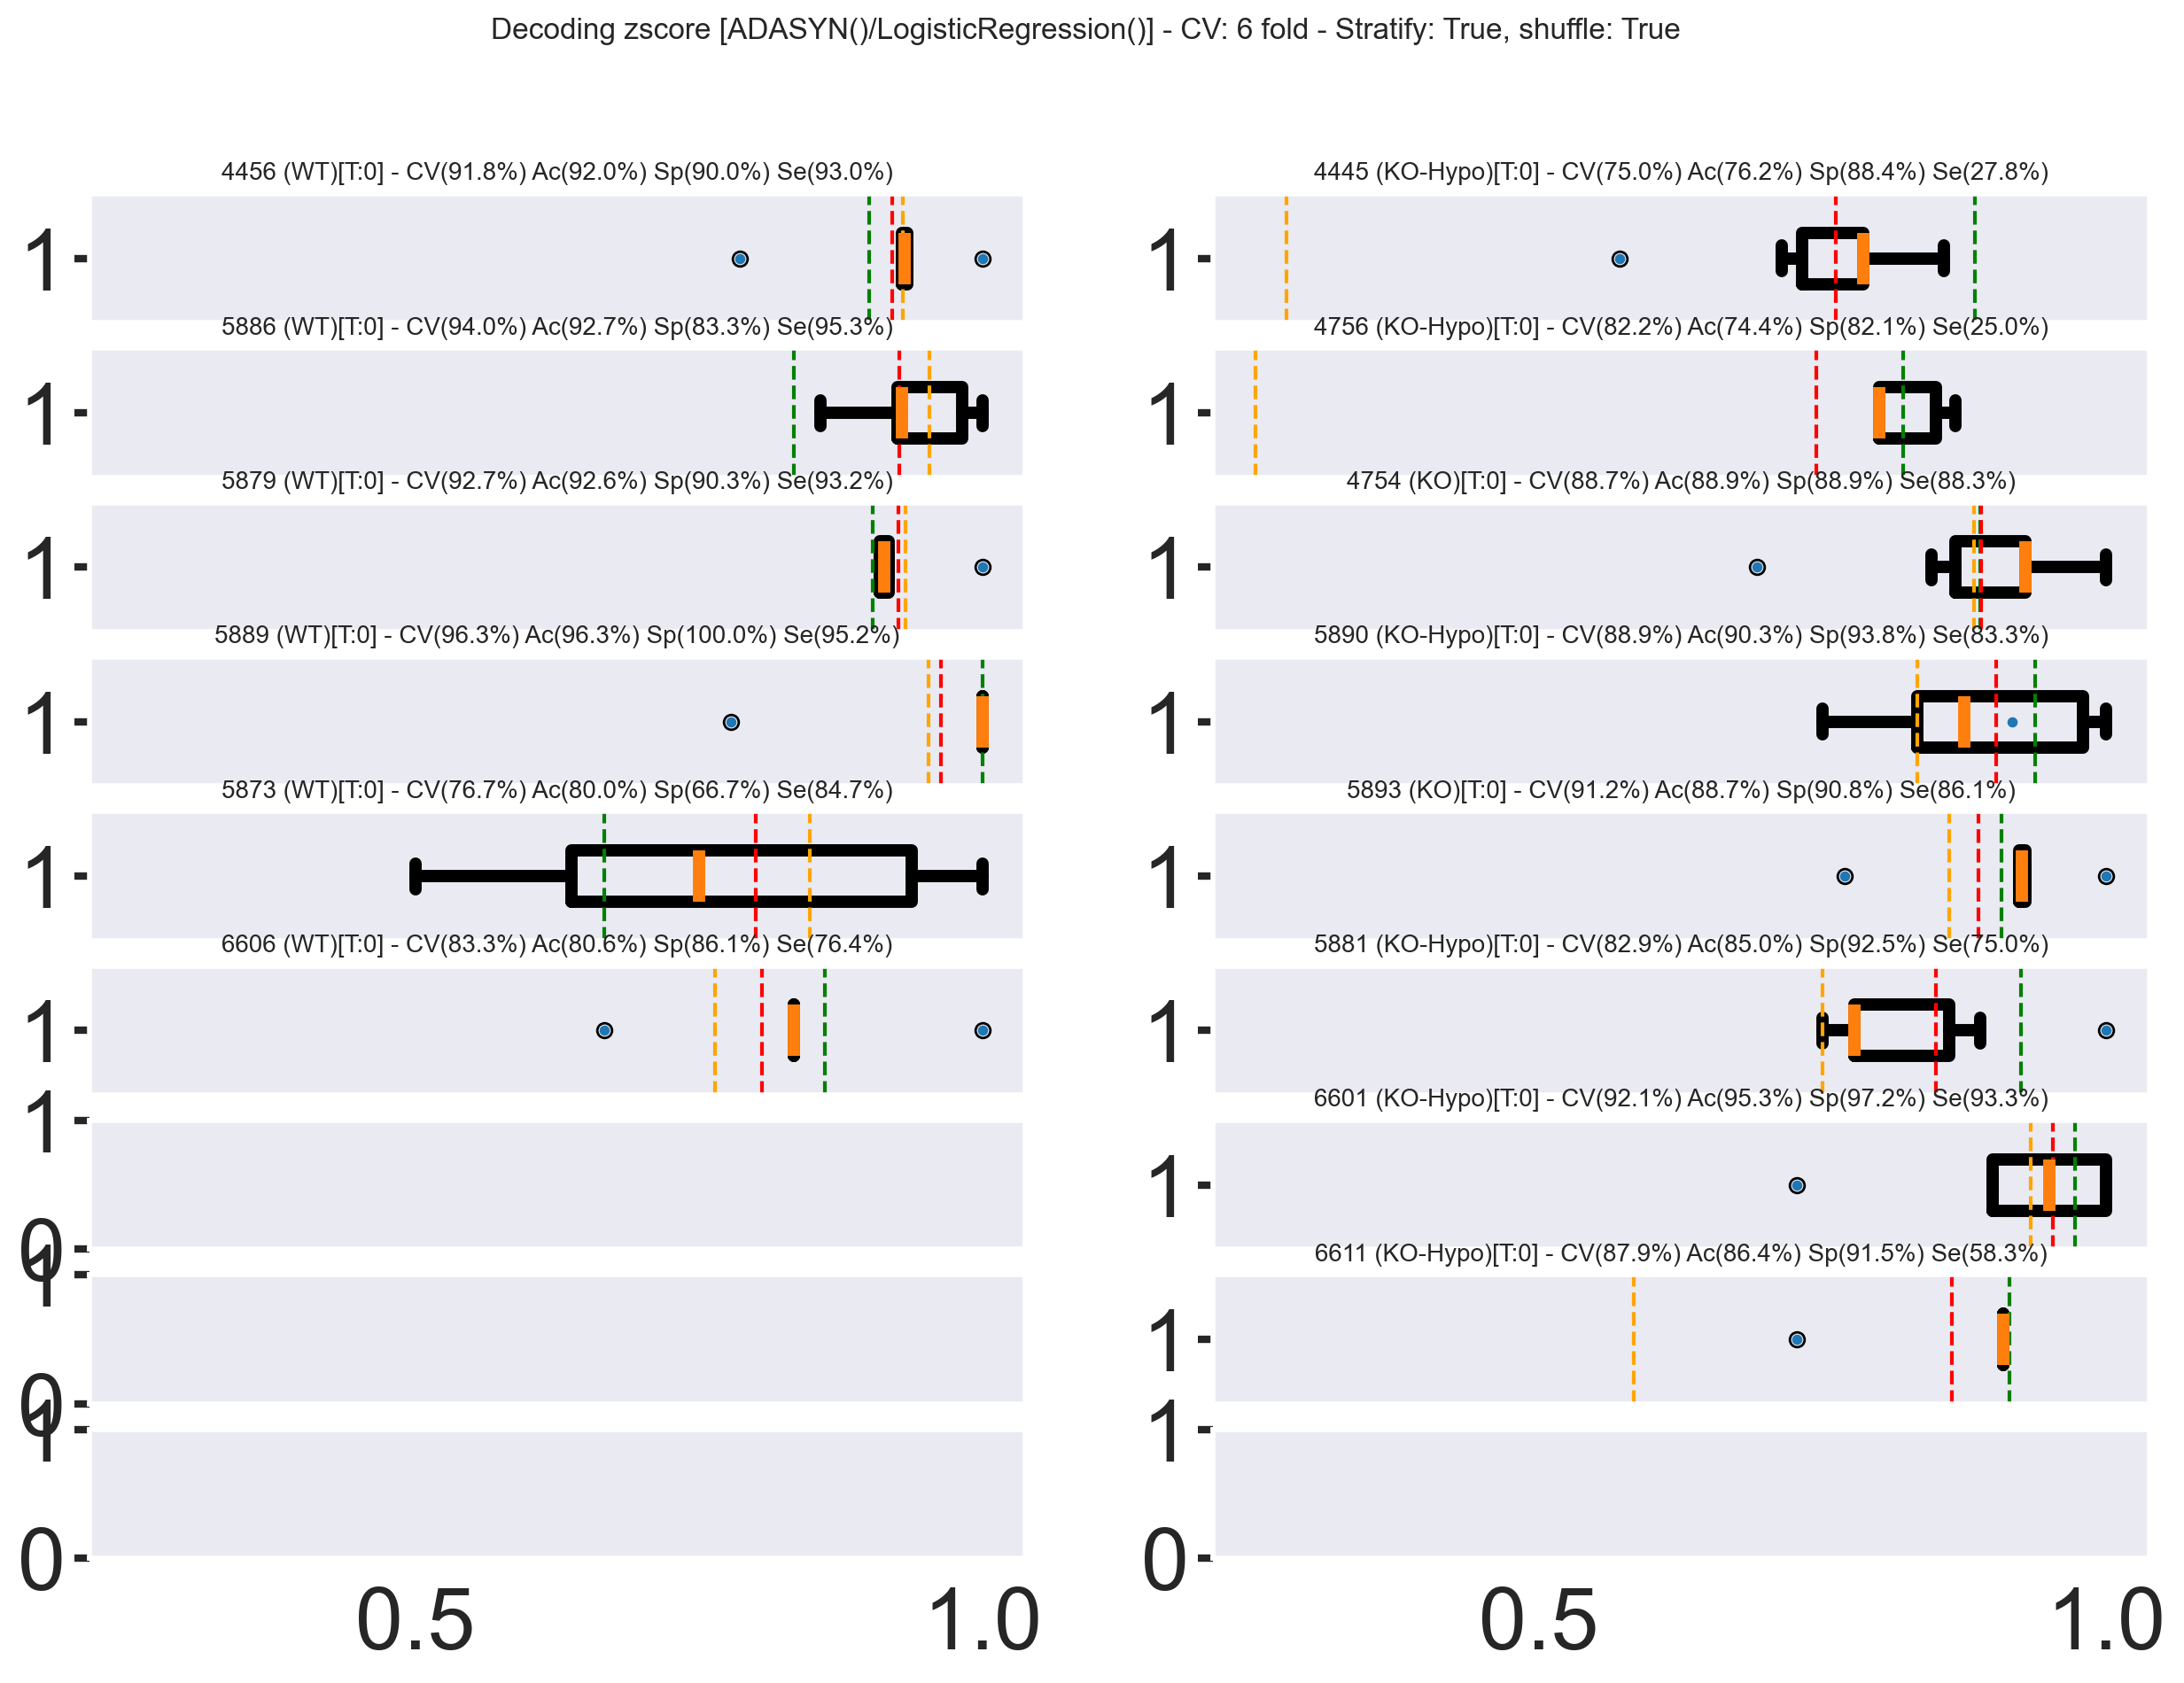

Boxplot plotting.
--- Accuracy: Detected ---
ShapiroResult(statistic=0.7988010093852854, pvalue=0.05733067880448603)
ShapiroResult(statistic=0.8977090585811875, pvalue=0.3605655835432615)
LeveneResult(statistic=7.921923488025191, pvalue=0.018329969572362725)
Unequal variances: TtestResult(statistic=2.399568265057277, pvalue=0.03734318300091872, df=10.0)
Boxplot plotting.
--- Accuracy: Undetected ---
ShapiroResult(statistic=0.9209700207862852, pvalue=0.5123746993316283)
ShapiroResult(statistic=0.9499839329261484, pvalue=0.7401518989018641)
LeveneResult(statistic=1.1355814068419696, pvalue=0.311640585299773)
Equal variances :TtestResult(statistic=-0.9687350454015388, pvalue=0.3555232156043565, df=10.0)
Boxplot plotting.
--- Accuracy: All ---
ShapiroResult(statistic=0.8066411210550022, pvalue=0.06738536516725509)
ShapiroResult(statistic=0.9445207996081211, pvalue=0.6957931198982866)
LeveneResult(statistic=0.16499598641579852, pvalue=0.693153944259191)
Equal variances :TtestResult(statisti

([[0.9296296296296296,
   0.9530303030303031,
   0.931547619047619,
   0.9523809523809524,
   0.8472222222222222,
   0.7638888888888888],
  [0.9,
   0.8333333333333334,
   0.9027777777777777,
   1.0,
   0.6666666666666666,
   0.8611111111111112],
  [0.9198412698412698,
   0.9267399267399267,
   0.9255050505050505,
   0.9629629629629629,
   0.7999999999999999,
   0.8055555555555555]],
 [[0.27777777777777773,
   0.25,
   0.8333333333333334,
   0.75,
   0.9333333333333332,
   0.5833333333333334],
  [0.883838383838384,
   0.8205128205128206,
   0.9375,
   0.9249999999999999,
   0.9722222222222223,
   0.9148148148148149],
  [0.7619047619047619,
   0.7444444444444445,
   0.9027777777777778,
   0.8495370370370369,
   0.9530303030303031,
   0.8636363636363636]])

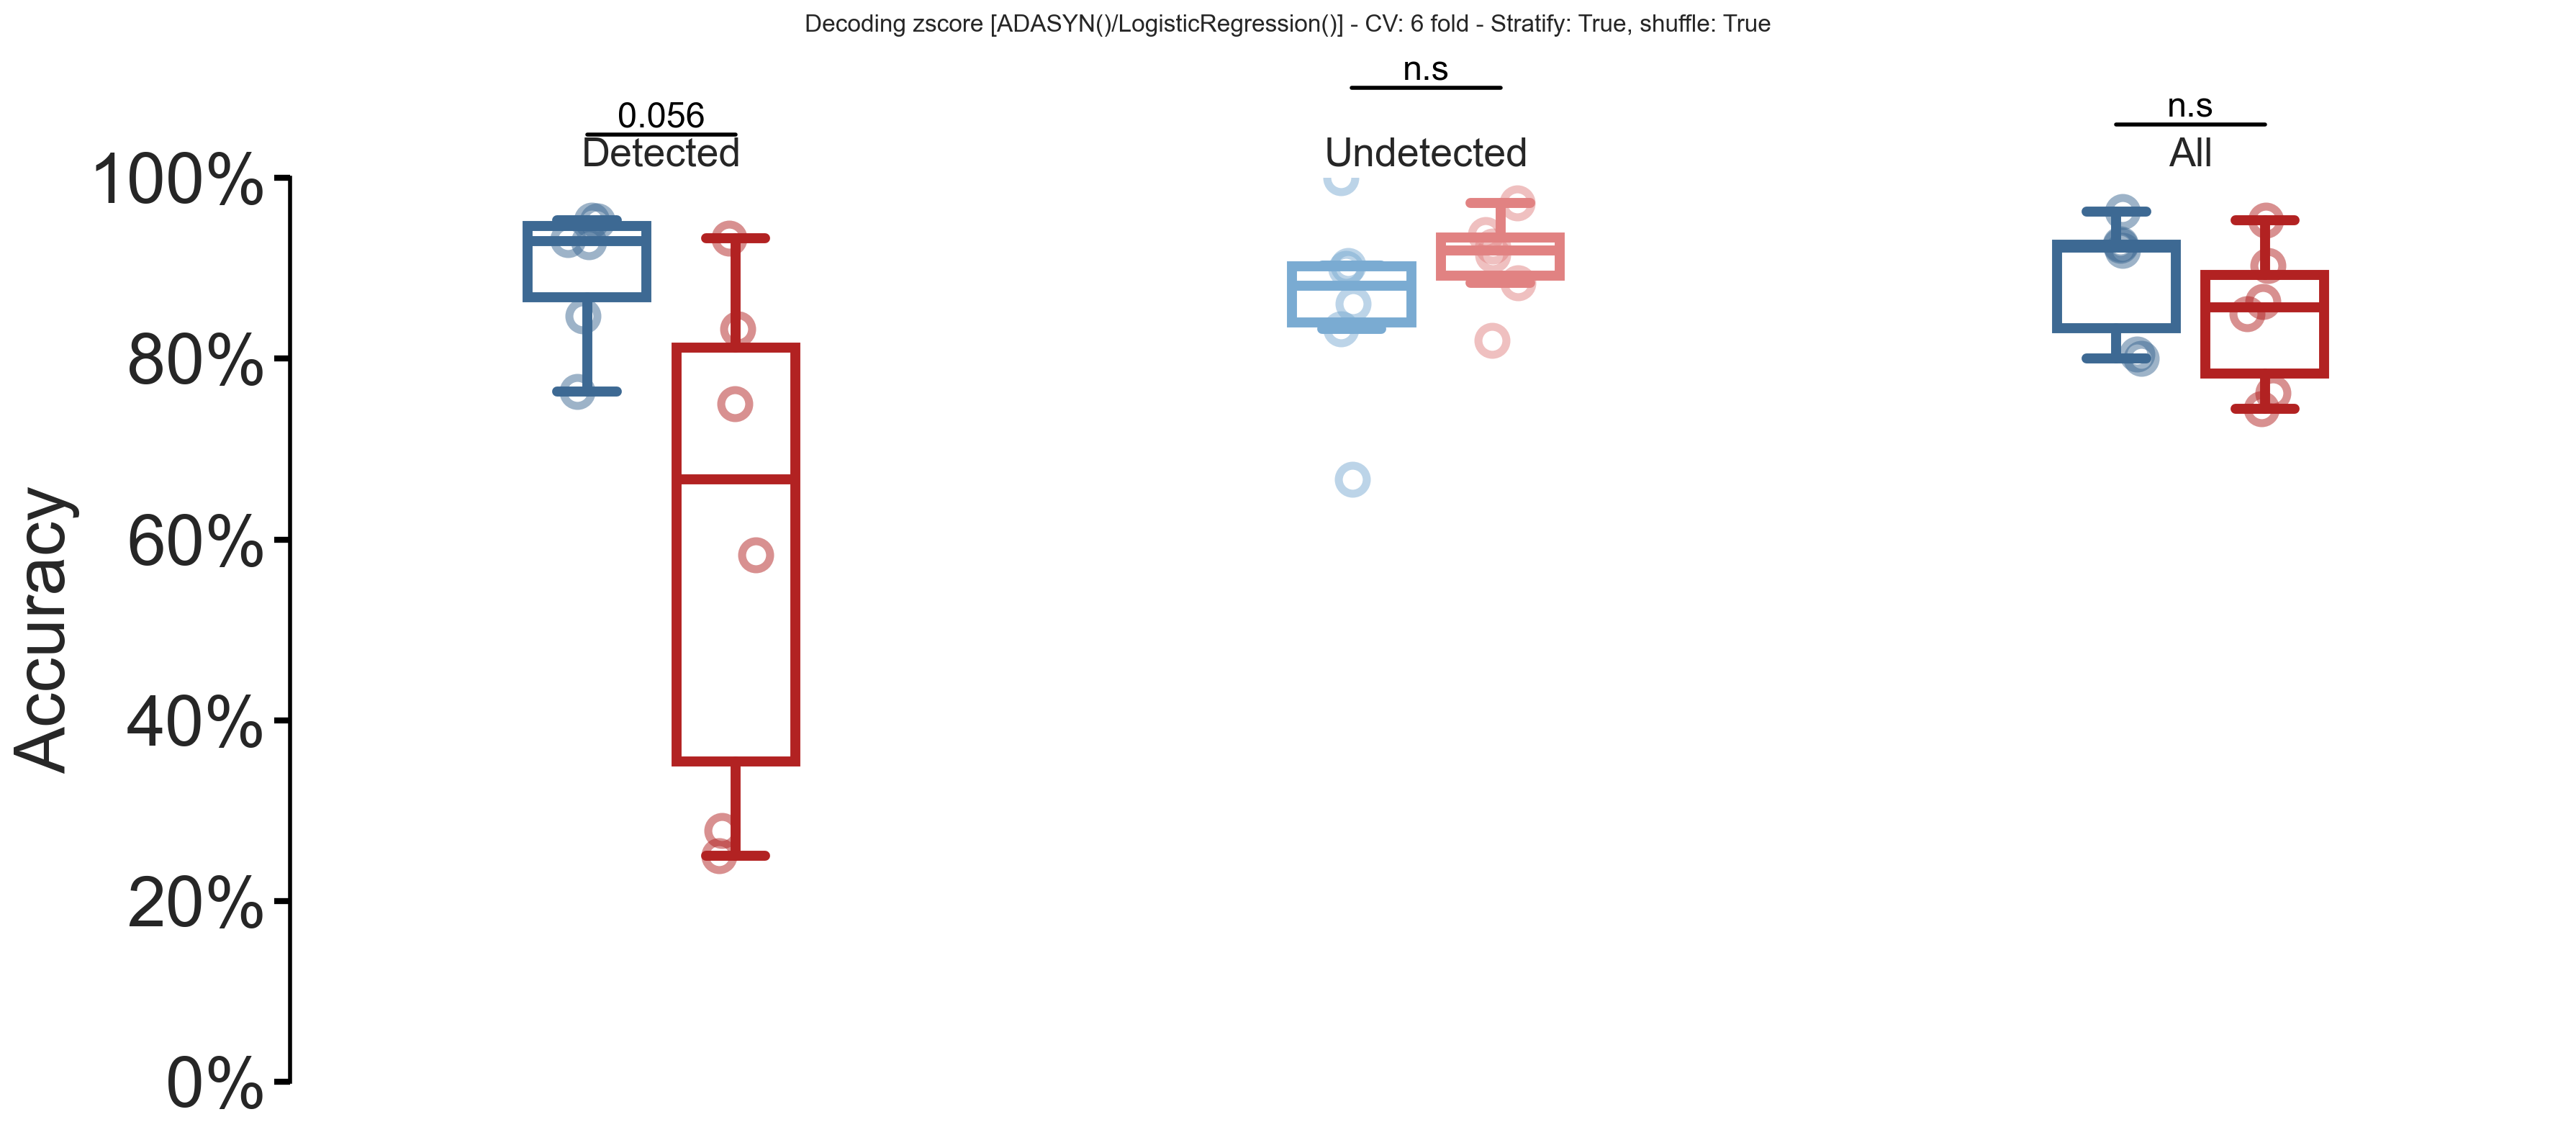

In [76]:
seed = 42

# Models
dum = DummyClassifier()
lr = LogisticRegression(penalty="l2")

# Resamplers
ros = imb.over_sampling.RandomOverSampler(sampling_strategy='auto', shrinkage=None)
rus = imb.under_sampling.RandomUnderSampler(sampling_strategy="auto")
smote = imb.over_sampling.SMOTE(sampling_strategy='auto')
adasyn = imb.over_sampling.ADASYN(sampling_strategy='auto')
mi_ros_mi_rus = "ROS-RUS"

apply_model(lr, "zscore", estimator="Mean", resampler=None, 
            exc_neurons=True, inh_neurons=True, amplitudes="all", 
            train_ratio=1, tt_stratify=False, 
            cv_stratify=True, shuffle=True, cv=6, cv_resampler=adasyn, plot_cv_metrics=True, 
            seed=None, over_prop=0.25)

In [ ]:
apply_model(lr, "zscore", estimator="Mean", resampler=rus, 
            exc_neurons=True, inh_neurons=True, amplitudes="all", 
            train_ratio=0.8, tt_stratify=True, 
            cv_stratify=True, shuffle=True, cv=7, cv_resampler=rus, plot_cv_metrics=False, 
            seed=None)

# Decoding mean Z-score

---

In [ ]:
apply_model(lr, "zscore", estimator="Mean", resampler=ros, exc_neurons=True, inh_neurons=True, amplitudes="all", train_ratio=0.8, cv=5, stratify=True, seed=seed, plot_cv_metrics=True)

# Decoding Std zscore

---

In [ ]:
apply_model(lr, "zscore", estimator="Std", resampler=rus, exc_neurons=True, inh_neurons=True, amplitudes="all", train_ratio=0.8, cv=5, stratify=True, seed=seed, plot_cv_metrics=True)

# Oversampling visualization

---

In [ ]:
rec = recs[6609]
test = get_rec_info(rec, "Responsivity", exc_neurons=True, inh_neurons=True)
test = stim_ampl_filter(test, "all")
ros = imb.over_sampling.RandomOverSampler(sampling_strategy='auto', shrinkage=None)
# bd_smote = imb.over_sampling.BorderlineSMOTE(sampling_strategy='auto')
# adasyn = imb.over_sampling.ADASYN(sampling_strategy="auto")
test = split_data(test, train_ratio=0.8, stratify=True)

test = resample(test, ros)
# test_2 = resample(copy.copy(test), smote)
# test_3 = resample(copy.copy(test), bd_smote)
# test_4 = resample(copy.copy(test), adasyn)
resp_heatmap(test, sort=True)
# resp_heatmap(test_2, sort=True)
# resp_heatmap(test_3, sort=True)
# resp_heatmap(test_4, sort=True)

================= over: 0.1 =================
_______________ under: 0.1 _______________
n_hit: 17, n_miss: 67, minority: 17 Hit
-> min_bal: 6.7, maj_bal: 67.0, real_trials: 84.0, generated_trial: -10.3, opti_ratio: -7.155339805825243
n_hit: 58, n_miss: 29, minority: 29 Miss
-> min_bal: 5.800000000000001, maj_bal: 58.00000000000001, real_trials: 87.0, generated_trial: -23.2, opti_ratio: -2.7499999999999996
n_hit: 25, n_miss: 30, minority: 25 Hit
-> min_bal: 3.0, maj_bal: 30.0, real_trials: 55.0, generated_trial: -22.0, opti_ratio: -1.5
n_hit: 12, n_miss: 78, minority: 12 Hit
-> min_bal: 7.800000000000001, maj_bal: 78.0, real_trials: 90.0, generated_trial: -4.199999999999999, opti_ratio: -20.42857142857143
n_hit: 61, n_miss: 21, minority: 21 Miss
-> min_bal: 6.1000000000000005, maj_bal: 61.0, real_trials: 82.0, generated_trial: -14.899999999999999, opti_ratio: -4.503355704697986
n_hit: 25, n_miss: 29, minority: 25 Hit
-> min_bal: 2.9000000000000004, maj_bal: 29.000000000000004, real_tri

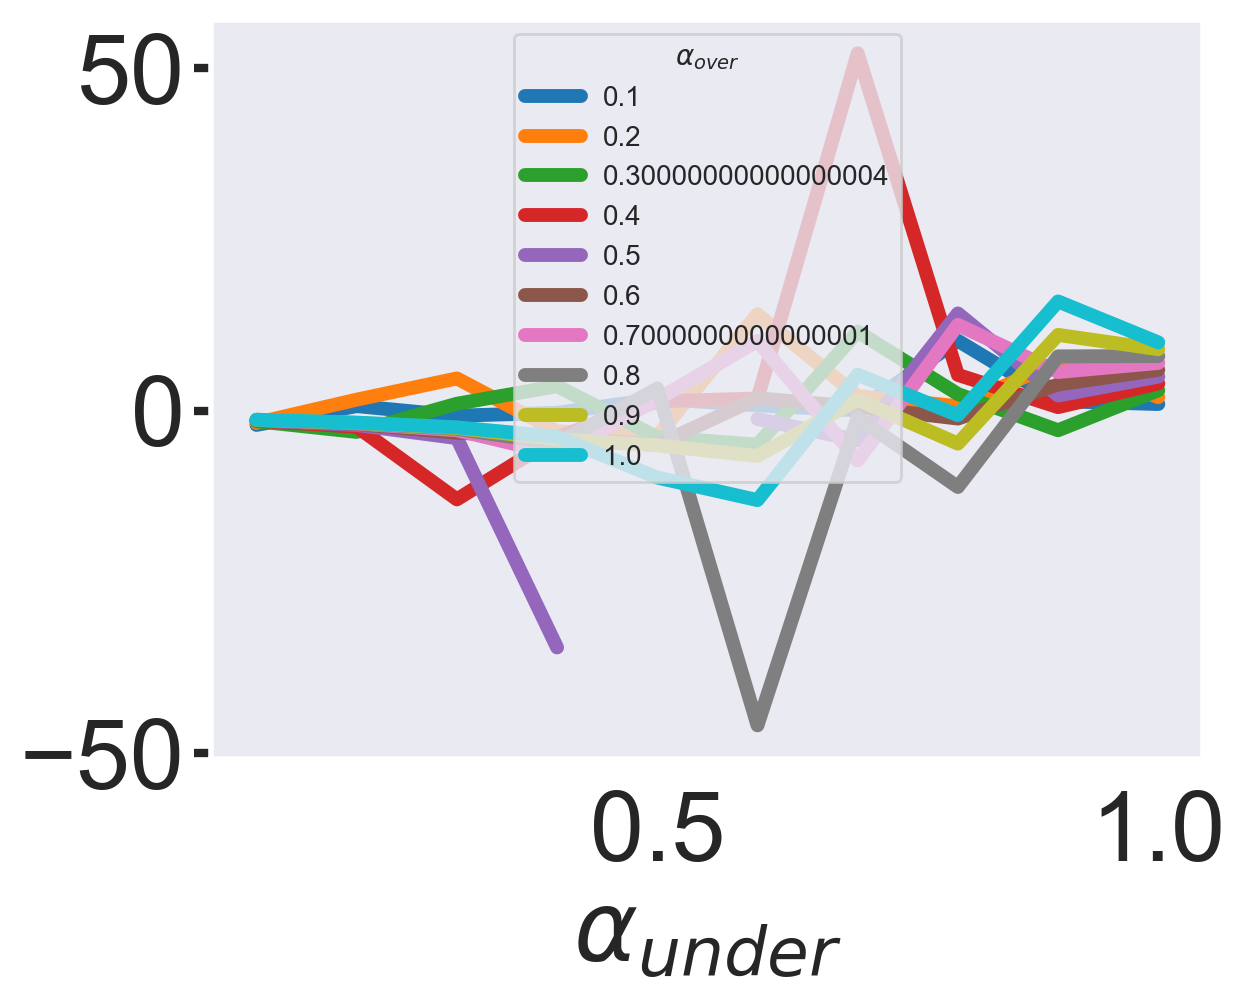

In [48]:
def compute_os_us(minority, majority, over, under):
    min_bal = majority * over
    maj_bal = min_bal / under
    real_trials = minority + maj_bal
    generated_trial = min_bal - minority
    deleted_trials = majority - maj_bal
    real_ratio = real_trials / (real_trials+generated_trial)
    opti_ratio = (min_bal + maj_bal) / (deleted_trials + generated_trial)
    
    print(f"-> min_bal: {min_bal}, maj_bal: {maj_bal}, real_trials: {real_trials}, generated_trial: {generated_trial}, opti_ratio: {opti_ratio}")
    return opti_ratio

x_vals = np.arange(0.1, 1.1, 0.1)
fig, ax = plt.subplots(nrows=1, ncols=1)
for over in x_vals:
    print(f"================= over: {over} =================")
    r_u_ratios = []
    r_u_std = []
    
    for under in x_vals:
        print(f"_______________ under: {under} _______________")
        
        r_ind_ratios = []
        for i in range(len(summary)):
            if not summary["ID"][i] == 5896:
                n_hit = int(summary["stim_True"][i])
                n_miss = int(summary["stim_False"][i])
                if n_hit < n_miss:
                    minority = n_hit
                    majority = n_miss
                    gen_lab = "Hit"
                else:
                    minority = n_miss
                    majority = n_hit
                    gen_lab = "Miss"
                print(f"n_hit: {n_hit}, n_miss: {n_miss}, minority: {minority} {gen_lab}")
                r_ind_ratios.append(compute_os_us(minority, majority, over, under))
        r_u_ratios.append(mean(np.array(r_ind_ratios)))
        r_u_std.append(np.std(np.array(r_ind_ratios)))
        
    ax.plot(x_vals, r_u_ratios, label=over)
    ax.set_xlabel(r"$\alpha_{under}$")
plt.legend(title=r"$\alpha_{over}$")
plt.show()
    # ax.fill_between(x_vals, r_u_ratios[loc]-r_u_std, r_u_ratios[loc]+r_u_std, alpha=0.2)
    # ax[loc].set_title(r"$\alpha_{over}$ = " + f"{over:.2f}")